# 변형: 박스 기울기 추정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 데이터 준비

In [2]:
original_trade_df = pd.read_csv('250505_standard_choi_trade_df.csv')
original_price = pd.read_csv('250505_standard_choi_price.csv')

In [3]:
original_trade_df.head()

,Unnamed: 0,Entry Time,Exit Time,pair,Entry Position,Held Positions,Conflict Action,Trade Profit,Trade Return (%),Entry Capital,...,Entry Price BNB,Exit Price BNB,Entry Price CVC,Exit Price CVC,Entry Price HIVE,Exit Price HIVE,Entry Price RAD,Exit Price RAD,Entry Price SFP,Exit Price SFP
0,0,2025-03-22 04:45:00,2025-03-22 09:55:00,"('CVC', 'RAD')",-1,{},none,221.581120,2.355899,9405.374048,...,NaN,NaN,0.0987,0.0995,NaN,NaN,0.805,0.859,NaN,NaN
1,1,2025-03-22 04:55:00,2025-03-22 10:55:00,"('BNB', 'AVA')",-1,"{'CVC': -1, 'RAD': 1}",none,34.166994,0.363271,9405.374048,...,629.98,628.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2025-03-22 06:25:00,2025-03-22 10:55:00,"('BNB', 'HIVE')",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -1, 'AVA': 1}",none,35.394876,0.376326,9405.374048,...,631.55,628.19,NaN,NaN,0.2375,0.238,NaN,NaN,NaN,NaN
3,3,2025-03-22 07:35:00,2025-03-22 10:30:00,"('CVC', 'SFP')",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -2, 'AVA': 1, 'HI...",none,29.816086,0.317011,9405.374048,...,NaN,NaN,0.0994,0.0990,NaN,NaN,NaN,NaN,0.5399,0.5422
4,4,2025-03-22 12:50:00,2025-03-22 15:50:00,"('CVC', 'SFP')",-1,{},none,21.195449,0.224643,9435.190134,...,NaN,NaN,0.0993,0.0992,NaN,NaN,NaN,NaN,0.5404,0.5429


In [4]:
original_price.head()

,Date,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
0,2023-06-01 00:00:00,1875.63,27234.32,113.1,0.5156,0.891,90.54,0.07519,18.01,6.478,...,0.8302,0.000009,5.210,0.721,0.000085,0.02341,2.423,0.02957,0.2165,0.002536
1,2023-06-01 00:05:00,1875.96,27241.68,113.2,0.5160,0.890,90.62,0.07518,18.01,6.478,...,0.8299,0.000009,5.205,0.721,0.000084,0.02351,2.419,0.02957,0.2167,0.002531
2,2023-06-01 00:10:00,1884.79,27318.11,113.4,0.5155,0.893,90.97,0.07533,18.04,6.502,...,0.8331,0.000009,5.236,0.723,0.000085,0.02354,2.432,0.02964,0.2174,0.002539
3,2023-06-01 00:15:00,1884.79,27287.80,113.4,0.5132,0.893,91.00,0.07533,18.04,6.501,...,0.8322,0.000009,5.237,0.723,0.000085,0.02352,2.430,0.02964,0.2178,0.002538
4,2023-06-01 00:20:00,1886.40,27300.99,113.4,0.5129,0.893,91.22,0.07543,18.06,6.506,...,0.8326,0.000009,5.239,0.724,0.000085,0.02353,2.431,0.02961,0.2178,0.002535


trade_df  
1. Unnamed: 0 column 삭제
2. Entry Time, Exit Time datetime으로 변환
3. pair tuple로 변환  
   문자열: ('CVC', 'RAD') 이런 식으로 돼 있음.
    1. '(', ')' 제거
    2. "'" (따옴표) 제거
    3. 쉼표 앞 스페이스 제거
    4. 튜플로 변환

In [5]:
trade_df = original_trade_df.drop('Unnamed: 0', axis=1)
trade_df['Entry Time'] = pd.to_datetime(trade_df['Entry Time'])
trade_df['Exit Time'] = pd.to_datetime(trade_df['Exit Time'])
trade_df['pair'] = trade_df['pair'].apply(lambda x: x.strip('(')).apply(lambda x: x.strip(')'))\
    .apply(lambda x: x.replace("'", '')).apply(lambda x: x.replace(' ', '')).apply(lambda x: tuple(x.split(',')))
trade_df.head()

,Entry Time,Exit Time,pair,Entry Position,Held Positions,Conflict Action,Trade Profit,Trade Return (%),Entry Capital,Exit Capital,...,Entry Price BNB,Exit Price BNB,Entry Price CVC,Exit Price CVC,Entry Price HIVE,Exit Price HIVE,Entry Price RAD,Exit Price RAD,Entry Price SFP,Exit Price SFP
0,2025-03-22 04:45:00,2025-03-22 09:55:00,"(CVC, RAD)",-1,{},none,221.581120,2.355899,9405.374048,9626.955168,...,NaN,NaN,0.0987,0.0995,NaN,NaN,0.805,0.859,NaN,NaN
1,2025-03-22 04:55:00,2025-03-22 10:55:00,"(BNB, AVA)",-1,"{'CVC': -1, 'RAD': 1}",none,34.166994,0.363271,9405.374048,9439.541042,...,629.98,628.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-22 06:25:00,2025-03-22 10:55:00,"(BNB, HIVE)",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -1, 'AVA': 1}",none,35.394876,0.376326,9405.374048,9440.768924,...,631.55,628.19,NaN,NaN,0.2375,0.238,NaN,NaN,NaN,NaN
3,2025-03-22 07:35:00,2025-03-22 10:30:00,"(CVC, SFP)",-1,"{'CVC': -1, 'RAD': 1, 'BNB': -2, 'AVA': 1, 'HI...",none,29.816086,0.317011,9405.374048,9435.190134,...,NaN,NaN,0.0994,0.0990,NaN,NaN,NaN,NaN,0.5399,0.5422
4,2025-03-22 12:50:00,2025-03-22 15:50:00,"(CVC, SFP)",-1,{},none,21.195449,0.224643,9435.190134,9456.385583,...,NaN,NaN,0.0993,0.0992,NaN,NaN,NaN,NaN,0.5404,0.5429


price
1. Date column datetime으로 변환
2. Date column 인덱스로 만들기

In [6]:
price = original_price.set_index('Date', drop=True)
price.index = pd.to_datetime(price.index)
price.head()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,1875.63,27234.32,113.1,0.5156,0.891,90.54,0.07519,18.01,6.478,0.0924,...,0.8302,0.000009,5.210,0.721,0.000085,0.02341,2.423,0.02957,0.2165,0.002536
2023-06-01 00:05:00,1875.96,27241.68,113.2,0.5160,0.890,90.62,0.07518,18.01,6.478,0.0923,...,0.8299,0.000009,5.205,0.721,0.000084,0.02351,2.419,0.02957,0.2167,0.002531
2023-06-01 00:10:00,1884.79,27318.11,113.4,0.5155,0.893,90.97,0.07533,18.04,6.502,0.0924,...,0.8331,0.000009,5.236,0.723,0.000085,0.02354,2.432,0.02964,0.2174,0.002539
2023-06-01 00:15:00,1884.79,27287.80,113.4,0.5132,0.893,91.00,0.07533,18.04,6.501,0.0921,...,0.8322,0.000009,5.237,0.723,0.000085,0.02352,2.430,0.02964,0.2178,0.002538
2023-06-01 00:20:00,1886.40,27300.99,113.4,0.5129,0.893,91.22,0.07543,18.06,6.506,0.0922,...,0.8326,0.000009,5.239,0.724,0.000085,0.02353,2.431,0.02961,0.2178,0.002535


## 1. 검증

### scaledPrice()  
1. trade_df의 거래내역 중 하나를 뽑아옴.
2. 거래내역의 기간과 페어 코인, price 데이터 연동
3. 연동된 price 데이터에 대해 minmax scaling 수행
4. 그래프 그림

In [33]:
def scaledPrice(rownum) :
    # Scaled price 만들기
    row = trade_df.iloc[rownum]; print('rownum:', rownum)
    
    pair = row['pair']
    pair1 = pair[0]; print('pair1:', pair1)
    pair2 = pair[1]; print('pair2:', pair2)
    entry_date = row['Entry Time']; print('Entry:', entry_date)
    exit_date = row['Exit Time']; print('Exit:', exit_date)
    
    print('Trade Profit:', row['Trade Profit'])
    print('Trade Return:', row['Trade Return (%)'], '%')
    print('Entry Capital:', row['Entry Capital'])
    print('Exit Capital:', row['Exit Capital'])
    
    mMscaler = MinMaxScaler()
    
    pair1_df = price[pair1].loc[(price.index >= entry_date) & (price.index <= exit_date)]
    pair2_df = price[pair2].loc[(price.index >= entry_date) & (price.index <= exit_date)]
    pair_df = pd.concat([pair1_df, pair2_df], axis=1)
    
    pair_df_scaled = pd.DataFrame(mMscaler.fit_transform(pair_df.values), index=pair_df.index, columns=pair_df.columns)

    # 그래프 그리기
    plt.plot(pair_df_scaled[pair1], label=pair1)
    plt.plot(pair_df_scaled[pair2], label=pair2)
    plt.title(f'Scaled Price of {pair1}, {pair2} (iloc[{rownum}])')
    plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
    plt.legend()
    plt.show()

rownum: 70
pair1: CVC
pair2: SFP
Entry: 2025-04-13 01:00:00
Exit: 2025-04-14 05:25:00
Trade Profit: 390.02392626257
Trade Return: 3.778142346324435 %
Entry Capital: 10323.166532939256
Exit Capital: 10713.190459201824


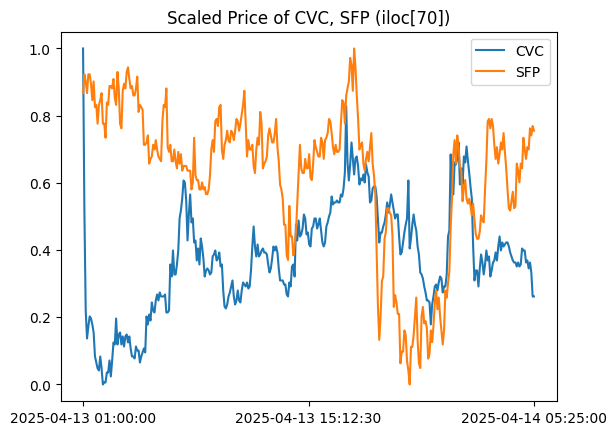

In [36]:
scaledPrice(70)

### pair의 평균 가격 데이터 생성

In [61]:
rownum = 0
# Scaled price 만들기
row = trade_df.iloc[rownum]; print('rownum:', rownum)

pair = row['pair']
pair1 = pair[0]; print('pair1:', pair1)
pair2 = pair[1]; print('pair2:', pair2)
entry_date = row['Entry Time']
exit_date = row['Exit Time']

mMscaler = MinMaxScaler()

pair1_df = price[pair1].loc[(price.index >= entry_date) & (price.index <= exit_date)]
pair2_df = price[pair2].loc[(price.index >= entry_date) & (price.index <= exit_date)]
pair_df = pd.concat([pair1_df, pair2_df], axis=1)

pair_df_scaled = pd.DataFrame(mMscaler.fit_transform(pair_df.values), index=pair_df.index, columns=pair_df.columns)

rownum: 0
pair1: CVC
pair2: RAD


In [63]:
pair_df_scaled['mean'] = (pair_df_scaled[pair1] + pair_df_scaled[pair2]) / 2
pair_df_scaled

,CVC,RAD,mean
Date,,,
2025-03-22 04:45:00,0.083333,0.000000,0.041667
2025-03-22 04:50:00,0.083333,0.037037,0.060185
2025-03-22 04:55:00,0.000000,0.037037,0.018519
2025-03-22 05:00:00,0.000000,0.037037,0.018519
2025-03-22 05:05:00,0.000000,0.037037,0.018519
...,...,...,...
2025-03-22 09:35:00,1.000000,0.333333,0.666667
2025-03-22 09:40:00,1.000000,0.333333,0.666667
2025-03-22 09:45:00,1.000000,0.407407,0.703704


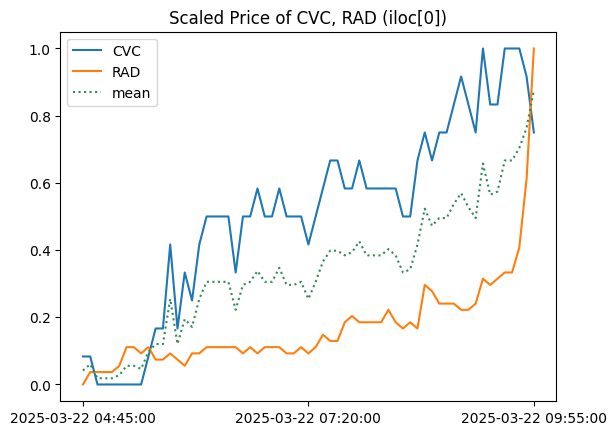

In [65]:
plt.plot(pair_df_scaled[pair1], label=pair1)
plt.plot(pair_df_scaled[pair2], label=pair2)
plt.plot(pair_df_scaled['mean'], label='mean', color='seagreen', linestyle=':')
plt.title(f'Scaled Price of {pair1}, {pair2} (iloc[{rownum}])')
plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
plt.legend()
plt.show()

### pair 평균 가격의 EOM, Signal 데이터 생성

* 변화량 = (당기고가+당기저가)/2 - (전기고가+전기저가)/2
* BoxRatio = (거래량/scale)/(당기고가-당기저가)
* EOM(Ease of Movement) = 변화량/BoxRatio의 moving average. rolling = EOMroll
* Signal = EOM의 moving average. rolling = SIGroll

In [69]:
pair_df_scaled.head()

,CVC,RAD,mean
Date,,,
2025-03-22 04:45:00,0.083333,0.000000,0.041667
2025-03-22 04:50:00,0.083333,0.037037,0.060185
2025-03-22 04:55:00,0.000000,0.037037,0.018519
2025-03-22 05:00:00,0.000000,0.037037,0.018519
2025-03-22 05:05:00,0.000000,0.037037,0.018519


### GG(25.05.11. 01:12)

일단 오늘은 GG  
<br>
EOM을 만들려면 극복해야 할 게 너무 많음..  
일단 한 기를 몇 단위로 할지 정해야 하고  
한 기당 각 코인들의 고가와 저가를 일일히 구해와야 함.  
거기에다 거래량 데이터도 row와 연동해서 가져와야 하고  
그렇게 구해 온 거래량의 스케일은 몇이 적절할지도 정해야 함.

EOM, SIG
1. 거래량 데이터 불러오기, 전처리
2. 함수 만들기
    * 변화량
       * 기 나누기, 고가 저가 반환
       * 변화량 구하기
    * 박스
       * 거래량 데이터 연동해서 가져오기
       * 박스비 구하기
    * EOM
       * 변화량/박스
       * MA ROLLING 조정
    * SIG
       * MA ROLLING 조정

## 2. 구현

In [99]:
from sqlalchemy import create_engine
from ta.volume import EaseOfMovementIndicator

In [101]:
db_path = 'crypto_volume_5min_0415_final.db'
engine_vol = create_engine(f'sqlite:///{db_path}')

In [103]:
volume = pd.read_sql('merged_crypto_volume_5min', engine_vol)
volume.rename(columns={'Open time' : 'Date'}, inplace=True)
volume.set_index('Date', drop=True, inplace=True)
volume.index = pd.to_datetime(price.index)
volume.head()

,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,...,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00,1357.6231,125.12187,102.023,2730767.0,9658.4,1692.381,3799159.4,449.75,17478.72,274530.0,...,18255.93,1.956061e+10,549.01,842.0,1.868392e+08,3817.0,641.90,13667.0,12580.0,758280.0
2023-06-01 00:05:00,1090.9779,147.97599,52.981,5804303.0,25838.7,2708.695,761885.5,1699.90,6558.42,319309.0,...,68471.09,8.659414e+09,1572.21,6356.2,7.931474e+07,227850.0,72.95,1067.0,1671.0,30375.0
2023-06-01 00:10:00,8447.1240,570.23601,163.761,7373728.0,33641.9,5119.427,936347.6,2090.25,64037.82,111569.0,...,44254.14,1.130239e+10,5023.56,3121.1,1.431814e+08,133857.0,639.92,9980.0,2566.0,128174.0
2023-06-01 00:15:00,2498.1419,159.26643,98.891,2710027.0,18547.6,3335.320,849694.4,326.39,8397.89,278974.0,...,4826.11,2.572967e+10,1662.92,4511.8,1.244608e+08,52989.0,16.18,19565.0,5411.0,228530.0
2023-06-01 00:20:00,2268.9141,135.09665,67.690,5094731.0,40859.7,1937.425,569841.6,550.93,6634.51,280664.0,...,10119.57,2.681957e+10,388.66,1072.7,4.083851e+07,18329.0,597.05,13930.0,2083.0,8794.0


### EOM SIG

In [94]:
mean = pair_df_scaled['mean']
mean

Date
2025-03-22 04:45:00    0.041667
2025-03-22 04:50:00    0.060185
2025-03-22 04:55:00    0.018519
2025-03-22 05:00:00    0.018519
2025-03-22 05:05:00    0.018519
                         ...   
2025-03-22 09:35:00    0.666667
2025-03-22 09:40:00    0.666667
2025-03-22 09:45:00    0.703704
2025-03-22 09:50:00    0.763889
2025-03-22 09:55:00    0.875000
Name: mean, Length: 63, dtype: float64

In [96]:
type(mean)

pandas.core.series.Series

In [ ]:
mean_

In [75]:
pair_df_scaled['mean']

Date
2025-03-22 04:45:00    0.041667
2025-03-22 04:50:00    0.060185
2025-03-22 04:55:00    0.018519
2025-03-22 05:00:00    0.018519
2025-03-22 05:05:00    0.018519
                         ...   
2025-03-22 09:35:00    0.666667
2025-03-22 09:40:00    0.666667
2025-03-22 09:45:00    0.703704
2025-03-22 09:50:00    0.763889
2025-03-22 09:55:00    0.875000
Name: mean, Length: 63, dtype: float64

In [85]:
EaseOfMovementIndicator

ta.volume.EaseOfMovementIndicator

In [89]:
EaseOfMovementIndicator.ease_of_movement(pair_df_scaled['mean'])

AttributeError: 'Series' object has no attribute '_check_fillna'

In [91]:
pair_df_scaled['mean']

AttributeError: 'Series' object has no attribute '_check_fillna'

In [9]:
price.columns

Index(['ETH', 'BTC', 'BCH', 'XRP', 'EOS', 'LTC', 'TRX', 'ETC', 'LINK', 'XLM',
       ...
       'LUNA', 'SHIB', 'BAL', 'CTK', 'LUNC', 'SNT', 'BADGER', 'VIDT', 'NULS',
       'TROY'],
      dtype='object', length=223)

In [10]:
top_200 = ['CVC', 'RLC', 'RAD', 'UTK', 'AERGO', 'BTC', 'ETH', 'XRP', 'SOL', 'BNB', 'PEPE', 'DOGE', 'SUI', 'TRX', 'ADA', 'CAKE', 'LINK', 'EUR', 'LTC', 'AVAX', 'AUCTION', 'EOS', 'HBAR', 'UNI', 'NEAR', 'XLM', 'AAVE', 'OM', 'RUNE', 'DOT', 'ARB', 'VIDT', 'CRV', 'API3', 'LDO', 'OP', 'APT', 'FET', 'SHIB', 'RAY', 'GMT', 'FLOKI', 'ENS', 'FIL', 'CKB', 'BCH', 'MKR', 'INJ', 'VET', 'SUN', 'RARE', 'ETC', 'ALGO', 'SAND', 'GALA', 'LINA', 'CFX', 'ATOM', 'DYDX', 'ICP', 'HIFI', 'FXS', 'PAXG', 'RSR', 'APE', 'TRB', 'JASMY', 'SNT', 'WBTC', 'GRT', 'CTXC', 'SSV', 'STX', 'THETA', 'IOTA', 'COTI', 'SUSHI', 'AR', 'ACH', 'BAKE', 'ZEN', 'HIGH', 'QTUM', 'SKL', 'KAVA', 'ID', 'C98', 'RDNT', 'FIDA', 'CHZ', 'NEO', 'T', 'MAGIC', 'SPELL', 'YFI', 'LUNA', 'GLM', 'MANA', 'DF', 'PEOPLE', 'SYN', 'NMR', 'STORJ', 'EGLD', 'ROSE', 'ONE', 'IMX', 'LUNC', 'KDA', 'HFT', 'LPT', 'RVN', 'POLYX', 'SUPER', 'AXS', 'MINA', 'UMA', 'XVS', 'YGG', 'BURGER', 'PHA', 'WING', 'ARPA', 'ILV', 'MOVR', 'LEVER', 'AST', 'CELO', 'BEL', 'DASH', 'CVX', 'AGLD', 'DEXE', 'SCRT', 'ZEC', 'FARM', 'ACA', 'STG', 'SNX', 'CTK', 'STPT']

In [12]:
len(top_200)

141

### 250530 데이터 뽑기

In [ ]:
import datetime as dt

In [162]:
def scaledPrice_spared(rownum) :
    row = trade_df.iloc[rownum]; print('rownum:', rownum)
    
    pair = row['pair']
    pair1 = pair[0]; print('pair1:', pair1)
    pair2 = pair[1]; print('pair2:', pair2)
    entry_time = row['Entry Time']; print('Entry:', entry_date)
    exit_time = row['Exit Time']; print('Exit:', exit_date) 
    timespare = (exit_time - entry_time) * 0.1
    entry_time_spared = entry_time - timespare
    exit_time_spared = exit_time + timespare
    
    print('Trade Profit:', row['Trade Profit'])
    print('Trade Return:', row['Trade Return (%)'], '%')
    print('Entry Capital:', row['Entry Capital'])
    print('Exit Capital:', row['Exit Capital'])
    
    mMscaler = MinMaxScaler()
    
    pair1_df = price[pair1].loc[(price.index >= entry_time_spared) & (price.index <= exit_time_spared)]
    pair2_df = price[pair2].loc[(price.index >= entry_time_spared) & (price.index <= exit_time_spared)]
    pair_df = pd.concat([pair1_df, pair2_df], axis=1)
    
    pair_df_scaled = pd.DataFrame(mMscaler.fit_transform(pair_df.values), index=pair_df.index, columns=pair_df.columns)
    
    # 그래프 그리기
    plt.plot(pair_df_scaled[pair1], label=pair1)
    plt.plot(pair_df_scaled[pair2], label=pair2)
    plt.title(f'Scaled Price of {pair1}, {pair2}')
    plt.xticks([entry_date, entry_date+(exit_date-entry_date)/2, exit_date], [entry_date, entry_date+(exit_date-entry_date)/2, exit_date])
    plt.legend()
    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)

    #plt.scatter(entry_time, pair_df_scaled[pair1][entry_time], color='red', zorder=2, s=5)
    #plt.scatter(entry_time, pair_df_scaled[pair2][entry_time], color='red', zorder=2, s=5)
    plt.scatter(exit_time, pair_df_scaled[pair1][exit_time], color='red', zorder=2, s=20)

    plt.vlines(entry_time, 0, pair_df_scaled[pair1][entry_time], linestyle = '--', color='r')
    #plt.vlines(exit_time, 0, pair_df_scaled[pair1][exit_time], linestyle = '--', color='r')
    
    plt.show()

rownum: 0
pair1: CVC
pair2: RAD
Entry: 2025-03-22 04:45:00
Exit: 2025-03-22 09:55:00
Trade Profit: 221.58112004954367
Trade Return: 2.355899073433567 %
Entry Capital: 9405.374047989408
Exit Capital: 9626.955168038952


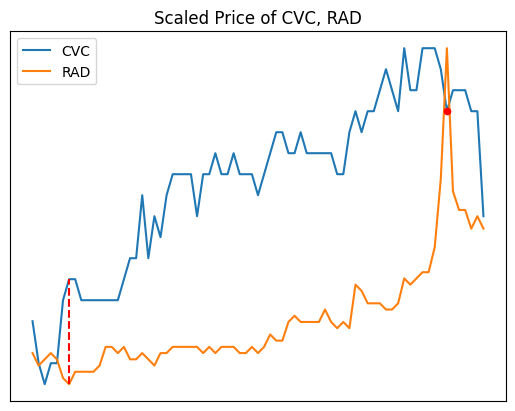

In [163]:
scaledPrice_spared(0)

rownum: 0
pair1: CVC
pair2: RAD
Entry: 2025-03-22 04:45:00
Exit: 2025-03-22 09:55:00
Trade Profit: 221.58112004954367
Trade Return: 2.355899073433567 %
Entry Capital: 9405.374047989408
Exit Capital: 9626.955168038952


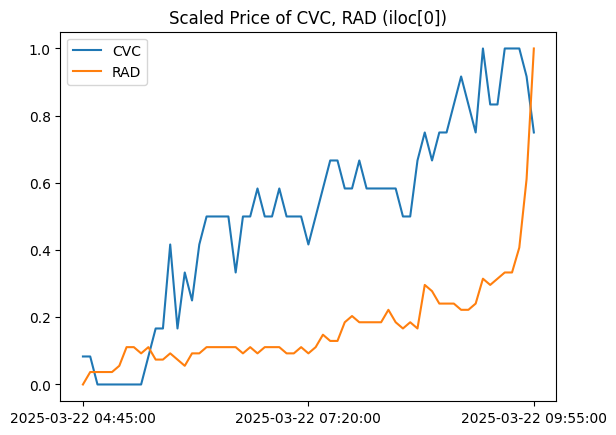

In [37]:
scaledPrice(0)

In [44]:
(exit_date - entry_date)*0.1

Timedelta('0 days 00:31:00')